<a href="https://colab.research.google.com/github/Shifoue/Segmentation/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install utils
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.0 MB/s eta 0:00:00


In [2]:
!unzip Dataset_Faces_training.zip
!unzip Dataset_Faces_validation.zip

!unzip Dataset_Faces_Mask_training.zip
!unzip Dataset_Faces_Mask_validation.zip

Archive:  Dataset_Faces_training.zip
   creating: Dataset_Faces_training/
  inflating: Dataset_Faces_training/1.jpg  
  inflating: Dataset_Faces_training/10.jpg  
  inflating: Dataset_Faces_training/100.jpg  
  inflating: Dataset_Faces_training/101.jpg  
  inflating: Dataset_Faces_training/102.jpg  
  inflating: Dataset_Faces_training/103.jpg  
  inflating: Dataset_Faces_training/104.jpg  
  inflating: Dataset_Faces_training/105.jpg  
  inflating: Dataset_Faces_training/106.jpg  
  inflating: Dataset_Faces_training/107.jpg  
  inflating: Dataset_Faces_training/108.jpg  
  inflating: Dataset_Faces_training/109.jpg  
  inflating: Dataset_Faces_training/11.jpg  
  inflating: Dataset_Faces_training/110.jpg  
  inflating: Dataset_Faces_training/111.jpg  
  inflating: Dataset_Faces_training/112.jpg  
  inflating: Dataset_Faces_training/113.jpg  
  inflating: Dataset_Faces_training/114.jpg  
  inflating: Dataset_Faces_training/115.jpg  
  inflating: Dataset_Faces_training/116.jpg  
  inflatin

In [3]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.depht = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, X):
        return self.depht(X)

class myUNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
      super(myUNET, self).__init__()
      self.encode = nn.ModuleList()
      self.decode = nn.ModuleList()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #divide size per 2

      # Encode
      for feature in features:
          self.encode.append(DoubleConv(in_channels, feature))
          in_channels = feature
      
      # Decode
      for feature in reversed(features):
          self.decode.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
          self.decode.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = []

        for depht in self.encode:
            X = depht(X)
            skip_connections.append(X)
            X = self.pool(X)

        X = self.bottleneck(X)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.decode), 2):
            X = self.decode[i](X)
            #skip_connection = skip_connections[-1 - i//2]
            skip_connection = skip_connections[i//2]

            if X.shape != skip_connection.shape:
                X = torch.nn.functional.interpolate(X, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, X), dim=1)
            X = self.decode[i+1](concat_skip)

        return self.final_conv(X)

def test():
    x = torch.randn((3, 1, 160, 160))
    m = myUNET(in_channels=1, out_channels=1)
    pred = m(x)

    assert pred.shape == x.shape

test()

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [21]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        #mask[mask == 255.0] = 1.0
        #mask = mask/255.0

        if self.transform is not None:

            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
import torchvision

In [40]:
#Hyperparamters

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 30
NUM_WORKERS = 2
IMAGE_HEIGHT = 218
IMAGE_WIDTH = 178
PIN_MEMORY = True
LOAD_MODEL = True
IMG_DIR_TRAIN = "/content/Dataset_Faces_training"
IMG_DIR_VAL = "/content/Dataset_Faces_validation"
MASK_DIR_TRAIN = "/content/Dataset_Faces_Mask_training"
MASK_DIR_VAL = "/content/Dataset_Faces_Mask_validation"
SAVE_DIR = "Saved_Images"

In [41]:
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_data = FaceDataset(image_dir=train_dir, mask_dir=train_mask_dir, transform = train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_data = FaceDataset(image_dir=val_dir, mask_dir=val_mask_dir, transform = val_transform)
    val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0 #did i predict correctly
    num_pixels = 0 #how many pixel are correct Area accuracy

    #In order to force the algorithm on finding a good solution instead of only putting black pixel to get a good accuracy due to the small size of the target
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8 #calculate the intersection between ground truth and prediction

    print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100}:.2f")
    print(f"Dice score {dice_score/len(loader)}")

    model.train()

def save_predictions_as_imgs(loader, model, folder = "prediction_images/", device="cuda"):
    if not os.path.exists(SAVE_DIR):
      os.mkdir(SAVE_DIR)

    model.eval()

    for i , (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            torchvision.utils.save_image(preds, f"{folder}/pred_{i}.jpg")
            torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/truth_{i}.jpg")

In [42]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for i_batch, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

In [43]:
import torch.nn.functional as F

In [44]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [45]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        #A.Rotate(limit=35, p=1.0),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        ToTensorV2()
    ]
)

validation_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        ToTensorV2()
    ]
)

UNET = myUNET(in_channels=3, out_channels=1).to(DEVICE) #for multiple classes change out channels to number of classes
#loss_fn = nn.BCEWithLogitsLoss() # for multiple classes use cross entropy

loss_fn = DiceLoss() #Needed to force the NN to chose another strategy than putting every pixel to white
optimizer = optim.Adam(UNET.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
    IMG_DIR_TRAIN,
    MASK_DIR_TRAIN,
    IMG_DIR_VAL,
    MASK_DIR_VAL,
    BATCH_SIZE,
    train_transform,
    validation_transform,
    NUM_WORKERS,
    PIN_MEMORY
)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    #print(train_loader)
    train(train_loader, UNET, optimizer, loss_fn, scaler)

    checkpoint =  {
        "state_dict": UNET.state_dict(),
        "optimizer": optimizer.state_dict()
    }

    save_checkpoint(checkpoint)

    check_accuracy(val_loader, UNET, device=DEVICE)

    save_predictions_as_imgs(val_loader, UNET, folder="/content/Saved_Images", device=DEVICE)

100%|██████████| 50/50 [00:13<00:00,  3.66it/s, loss=-.286]


=> Saving checkpoint
Got 114098616/7760800 with accuracy 1470.19140625:.2f
Dice score 1.8005921840667725


100%|██████████| 50/50 [00:13<00:00,  3.76it/s, loss=-.781]


=> Saving checkpoint
Got 117008475/7760800 with accuracy 1507.6856689453125:.2f
Dice score 1.8285093307495117


100%|██████████| 50/50 [00:12<00:00,  3.99it/s, loss=-.946]


=> Saving checkpoint
Got 119723935/7760800 with accuracy 1542.6751708984375:.2f
Dice score 1.7756798267364502


100%|██████████| 50/50 [00:12<00:00,  4.07it/s, loss=-.93]


=> Saving checkpoint
Got 120302106/7760800 with accuracy 1550.1248779296875:.2f
Dice score 1.7614939212799072


100%|██████████| 50/50 [00:12<00:00,  4.01it/s, loss=-.898]


=> Saving checkpoint
Got 119818095/7760800 with accuracy 1543.888427734375:.2f
Dice score 1.8402642011642456


100%|██████████| 50/50 [00:12<00:00,  3.98it/s, loss=-.943]


=> Saving checkpoint
Got 119517810/7760800 with accuracy 1540.0191650390625:.2f
Dice score 1.8910588026046753


100%|██████████| 50/50 [00:12<00:00,  3.99it/s, loss=-.952]


=> Saving checkpoint
Got 119814334/7760800 with accuracy 1543.8399658203125:.2f
Dice score 1.906583547592163


100%|██████████| 50/50 [00:12<00:00,  4.03it/s, loss=-.955]


=> Saving checkpoint
Got 119955893/7760800 with accuracy 1545.6640625:.2f
Dice score 1.8931853771209717


100%|██████████| 50/50 [00:12<00:00,  4.06it/s, loss=-.957]


=> Saving checkpoint
Got 120283947/7760800 with accuracy 1549.8909912109375:.2f
Dice score 1.8349989652633667


100%|██████████| 50/50 [00:12<00:00,  4.00it/s, loss=-.954]


=> Saving checkpoint
Got 119806041/7760800 with accuracy 1543.7330322265625:.2f
Dice score 1.9050848484039307


100%|██████████| 50/50 [00:12<00:00,  4.02it/s, loss=-.921]


=> Saving checkpoint
Got 119988771/7760800 with accuracy 1546.0875244140625:.2f
Dice score 1.8864598274230957


100%|██████████| 50/50 [00:12<00:00,  4.02it/s, loss=-.959]


=> Saving checkpoint
Got 120212556/7760800 with accuracy 1548.97119140625:.2f
Dice score 1.8552740812301636


100%|██████████| 50/50 [00:12<00:00,  4.06it/s, loss=-.93]


=> Saving checkpoint
Got 119406936/7760800 with accuracy 1538.590576171875:.2f
Dice score 1.8331776857376099


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.925]


=> Saving checkpoint
Got 118802167/7760800 with accuracy 1530.7978515625:.2f
Dice score 1.8659430742263794


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.951]


=> Saving checkpoint
Got 120120869/7760800 with accuracy 1547.789794921875:.2f
Dice score 1.831020712852478


100%|██████████| 50/50 [00:12<00:00,  4.03it/s, loss=-.946]


=> Saving checkpoint
Got 119116327/7760800 with accuracy 1534.845947265625:.2f
Dice score 1.8852591514587402


100%|██████████| 50/50 [00:12<00:00,  4.01it/s, loss=-.94]


=> Saving checkpoint
Got 119899668/7760800 with accuracy 1544.939453125:.2f
Dice score 1.9014207124710083


100%|██████████| 50/50 [00:12<00:00,  4.01it/s, loss=-.949]


=> Saving checkpoint
Got 120013189/7760800 with accuracy 1546.4022216796875:.2f
Dice score 1.881859540939331


100%|██████████| 50/50 [00:12<00:00,  4.08it/s, loss=-.954]


=> Saving checkpoint
Got 120105765/7760800 with accuracy 1547.5950927734375:.2f
Dice score 1.8699883222579956


100%|██████████| 50/50 [00:12<00:00,  4.09it/s, loss=-.961]


=> Saving checkpoint
Got 120190336/7760800 with accuracy 1548.684814453125:.2f
Dice score 1.8804951906204224


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.959]


=> Saving checkpoint
Got 120082964/7760800 with accuracy 1547.30126953125:.2f
Dice score 1.8884644508361816


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.959]


=> Saving checkpoint
Got 120104694/7760800 with accuracy 1547.581298828125:.2f
Dice score 1.8726015090942383


100%|██████████| 50/50 [00:12<00:00,  4.03it/s, loss=-.961]


=> Saving checkpoint
Got 119966212/7760800 with accuracy 1545.796875:.2f
Dice score 1.882737159729004


100%|██████████| 50/50 [00:12<00:00,  4.02it/s, loss=-.957]


=> Saving checkpoint
Got 120232928/7760800 with accuracy 1549.233642578125:.2f
Dice score 1.8452290296554565


100%|██████████| 50/50 [00:12<00:00,  4.04it/s, loss=-.959]


=> Saving checkpoint
Got 120077590/7760800 with accuracy 1547.2320556640625:.2f
Dice score 1.8583054542541504


100%|██████████| 50/50 [00:12<00:00,  4.06it/s, loss=-.963]


=> Saving checkpoint
Got 120200883/7760800 with accuracy 1548.8206787109375:.2f
Dice score 1.850553035736084


100%|██████████| 50/50 [00:12<00:00,  4.09it/s, loss=-.957]


=> Saving checkpoint
Got 120161269/7760800 with accuracy 1548.310302734375:.2f
Dice score 1.8796491622924805


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.961]


=> Saving checkpoint
Got 120357947/7760800 with accuracy 1550.844482421875:.2f
Dice score 1.8152071237564087


100%|██████████| 50/50 [00:12<00:00,  4.07it/s, loss=-.956]


=> Saving checkpoint
Got 120028564/7760800 with accuracy 1546.6002197265625:.2f
Dice score 1.8775732517242432


100%|██████████| 50/50 [00:12<00:00,  4.05it/s, loss=-.965]


=> Saving checkpoint
Got 120324166/7760800 with accuracy 1550.4093017578125:.2f
Dice score 1.8470748662948608


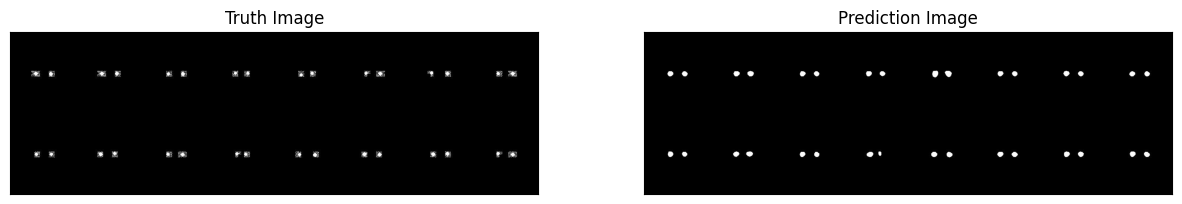

In [47]:
import matplotlib.pyplot as plt

truth_image = Image.open('/content/Saved_Images/truth_0.jpg')
pred_image = Image.open('/content/Saved_Images/pred_0.jpg')


figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(truth_image)
plt.title('Truth Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(pred_image)
plt.title('Prediction Image'), plt.xticks([]), plt.yticks([])
plt.show()